This is the sixth blog post of [Object Detection with YOLO blog series](https://fairyonice.github.io/tag/object-detection-using-yolov2-on-pascal-voc2012-series.html). This blog performs inference using the model in trained in [Part 5 Object Detection with Yolo using VOC 2012 data - training](https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html).
I will use PASCAL VOC2012 data. 
This blog assumes that the readers have read the previous two blog posts - [Part 1](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html), [Part 2](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html), [Part 3](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html), [Part 4](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html), [Part 5](https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html).

## Andrew Ng's YOLO lecture
- [Neural Networks - Bounding Box Predictions](https://www.youtube.com/watch?v=gKreZOUi-O0&t=0s&index=7&list=PL_IHmaMAvkVxdDOBRg2CbcJBq9SY7ZUvs)
- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE&t=7s)
- [C4W3L07 Nonmax Suppression](https://www.youtube.com/watch?v=VAo84c1hQX8&t=192s)
- [C4W3L08 Anchor Boxes](https://www.youtube.com/watch?v=RTlwl2bv0Tg&t=28s)
- [C4W3L09 YOLO Algorithm](https://www.youtube.com/watch?v=9s_FpMpdYW8&t=34s)


## Reference
- [You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf) 

- [YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf)
 
- [experiencor/keras-yolo2](https://github.com/experiencor/keras-yolo2)

## Reference in my blog
- [Part 1 Object Detection using YOLOv2 on Pascal VOC2012 - anchor box clustering](https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html)

- [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)

- [Part 3 Object Detection using YOLOv2 on Pascal VOC2012 - model](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html)

- [Part 4 Object Detection using YOLOv2 on Pascal VOC2012 - loss](https://fairyonice.github.io/Part_4_Object_Detection_with_Yolo_using_VOC_2012_data_loss.html)

- [Part 5 Object Detection using YOLOv2 on Pascal VOC2012 - training](https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html)

## My GitHub repository 
This repository contains all the ipython notebook for this blog series and the funcitons. 
- [FairyOnIce/ObjectDetectionYolo](https://github.com/FairyOnIce/ObjectDetectionYolo)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
print(sys.version)
%matplotlib inline

3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


Read in the hyperparameters to define the YOLOv2 model used during training 

In [2]:
train_image_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "../ObjectDetectionRCNN/VOCdevkit/VOC2012/Annotations/"

LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height


BOX               = int(len(ANCHORS)/2)
TRUE_BOX_BUFFER   = 50
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13

Load the weights trained in [Part 5](https://fairyonice.github.io/Part_5_Object_Detection_with_Yolo_using_VOC_2012_data_training.html)

In [3]:
from backend import define_YOLOv2

CLASS             = len(LABELS)
model, _          = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, 
                                  trainable=False)
model.load_weights("weights_yumi.h5")

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Perform detection on sample image

### Encode the image using the ImageReader class 
ImageReader class was created in [Part 2](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html).

In [4]:
## input encoding
from backend import ImageReader
imageReader = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
out = imageReader.fit(train_image_folder + "/2007_005430.jpg")

### Predict the bounding box.

In [5]:
print(out.shape)
X_test = np.expand_dims(out,0)
print(X_test.shape)
# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])
print(y_pred.shape)

(416, 416, 3)
(1, 416, 416, 3)
(1, 13, 13, 4, 25)


### Rescale the network output
Remind you that <code>y_pred</code> takes any real values. 
Therefore

In [6]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)
    def get_shifting_matrix(self,netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[...,0]
        
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
       
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:,igrid_w,:] = igrid_w

        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W,
         mat_GRID_H,
         mat_ANCHOR_W,
         mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) + mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) + mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self._sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return(netout)

### Experiment <code>OutputRescaler</code>

In [7]:
netout         = y_pred[0]
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)

## Post processing the YOLOv2 object
YOLOv2 can potentially preoduce GRID_H x GRID_W x BOX many bounding box.
However, only few of them actually contain actual objects. 
Some bounding box may contain the same objects.
I will postprocess the predicted bounding box.  

In [8]:
from backend import BoundBox

    
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==
    
    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C 
    
             
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.score > obj_threshold:
                        boxes.append(box)
    return(boxes)


### Experiment <code>find_high_class_probability_bbox</code>

In [9]:
obj_threshold = 0.01
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.01
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 207 bounding boxes with top class probability > 0.01

obj_threshold=0.03
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 5 bounding boxes with top class probability > 0.03


## Visualize many bounding box by having small obj_threshold value 
Most of the bounding boxes do not contain objects. 
This shows that we really need to reduce the number of bounding box.

person          0.011 xmin= 330,ymin=   3,xmax= 403,ymax=  91
person          0.012 xmin= 305,ymin=   0,xmax= 416,ymax= 147
person          0.012 xmin=   0,ymin=   0,xmax= 108,ymax= 182
person          0.010 xmin=   0,ymin=   0,xmax= 151,ymax= 231
person          0.012 xmin= 113,ymin=   0,xmax= 236,ymax= 179
person          0.015 xmin= 146,ymin=   0,xmax= 268,ymax= 180
person          0.015 xmin= 177,ymin=   0,xmax= 303,ymax= 180
person          0.011 xmin= 206,ymin=   0,xmax= 330,ymax= 181
person          0.012 xmin=   0,ymin=  13,xmax= 107,ymax= 217
person          0.013 xmin=   0,ymin=   0,xmax= 151,ymax= 261
person          0.011 xmin=  53,ymin=  13,xmax= 175,ymax= 213
person          0.010 xmin=   3,ymin=   0,xmax= 212,ymax= 259
person          0.011 xmin=  84,ymin=  14,xmax= 205,ymax= 213
person          0.015 xmin= 117,ymin=  14,xmax= 237,ymax= 214
person          0.013 xmin= 150,ymin=  16,xmax= 270,ymax= 217
person          0.012 xmin= 106,ymin=   0,xmax= 313,ymax= 265
person  

pottedplant     0.026 xmin=   0,ymin= 252,xmax= 152,ymax= 416
pottedplant     0.020 xmin=  42,ymin= 353,xmax= 120,ymax= 416
pottedplant     0.027 xmin=  15,ymin= 302,xmax= 145,ymax= 416
person          0.023 xmin=   0,ymin= 222,xmax= 263,ymax= 416
pottedplant     0.024 xmin=   0,ymin= 253,xmax= 184,ymax= 416
pottedplant     0.019 xmin=  72,ymin= 353,xmax= 153,ymax= 416
pottedplant     0.027 xmin=  47,ymin= 302,xmax= 178,ymax= 416
person          0.025 xmin=   0,ymin= 222,xmax= 295,ymax= 416
pottedplant     0.024 xmin=   4,ymin= 253,xmax= 215,ymax= 416
bottle          0.025 xmin= 103,ymin= 354,xmax= 186,ymax= 416
pottedplant     0.026 xmin=  78,ymin= 303,xmax= 210,ymax= 416
person          0.028 xmin=   0,ymin= 222,xmax= 328,ymax= 416
pottedplant     0.026 xmin=  36,ymin= 254,xmax= 247,ymax= 416
bottle          0.022 xmin= 135,ymin= 353,xmax= 218,ymax= 416
pottedplant     0.020 xmin= 111,ymin= 303,xmax= 242,ymax= 416
person          0.018 xmin=   0,ymin= 223,xmax= 360,ymax= 416
pottedpl

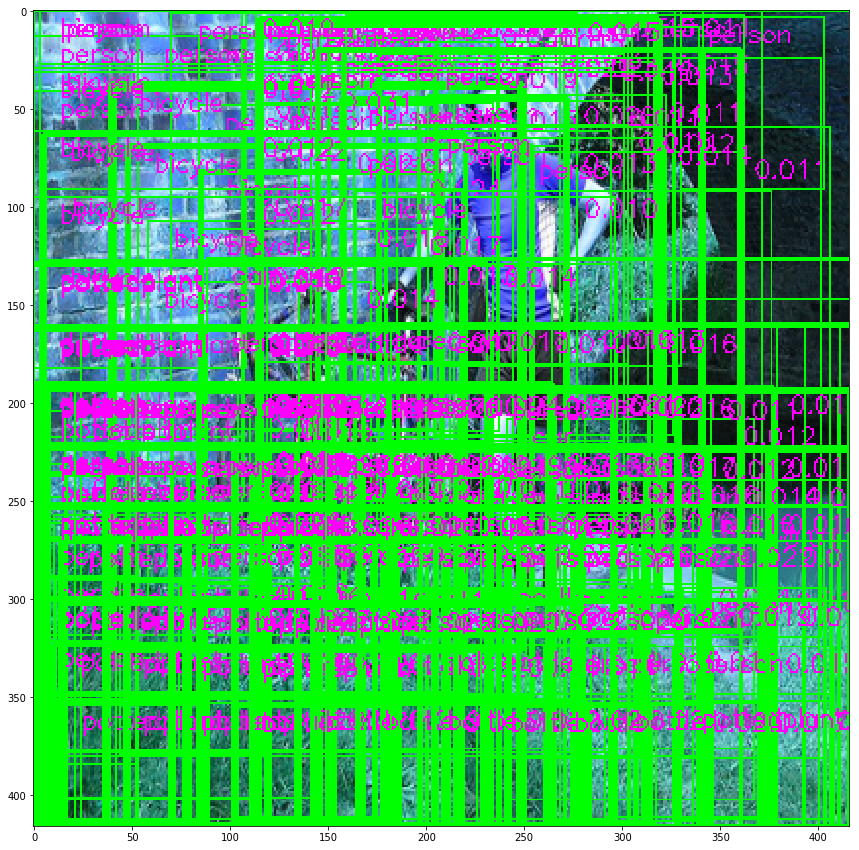

In [10]:
import cv2, copy
def draw_boxes(image, boxes, labels):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.score for box in boxes])
    score_rescaled /= np.min(score_rescaled)
    for sr, box in zip(score_rescaled,boxes):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:15} {:4.3f}".format(labels[box.label], box.score)
        print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=(0,1,0), 
                      thickness=sr)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)
        
    return image



ima = draw_boxes(X_test[0],boxes_tiny_threshold,LABELS)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima[:,:,::-1]); 
plt.show()



### Nonmax surpression
Nonmax surpression is a way to detect a single object only once. 
Andrew Ng has presented the idea of nonmax supression in his lecture very well: [C4W3L07 Nonmax Suppression](https://www.youtube.com/watch?v=VAo84c1hQX8&t=192s).

The following code implement the nonmax surpression algorithm. 
For each object class, the algorithm picks the most promissing bounding box, and then remove (or suppress) the remaining bounding box that contain high overwrap with the most promissing bounding box.
The most promissing or not is determined by the predicted class probaiblity.

In [11]:
from backend import BestAnchorBoxFinder
def nonmax_suppression(boxes,nms_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS = len(boxes[0].classes)
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    if bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    
    return boxes    


### Experiment <code>nonmax_suppression</code>

In [12]:
final_boxes = nonmax_suppression(boxes,nms_threshold=0.1)
print("{} final number of boxes".format(len(final_boxes)))

5 final number of boxes


## Finally draw the bounding box on an wapred image

person   0.036 xmin= 115,ymin=   5,xmax= 318,ymax= 297
bicycle  0.031 xmin=  40,ymin=  38,xmax= 249,ymax= 325
person   0.032 xmin=   0,ymin= 192,xmax= 232,ymax= 416
person   0.033 xmin=   0,ymin= 191,xmax= 264,ymax= 416
person   0.030 xmin=  78,ymin= 269,xmax= 210,ymax= 416


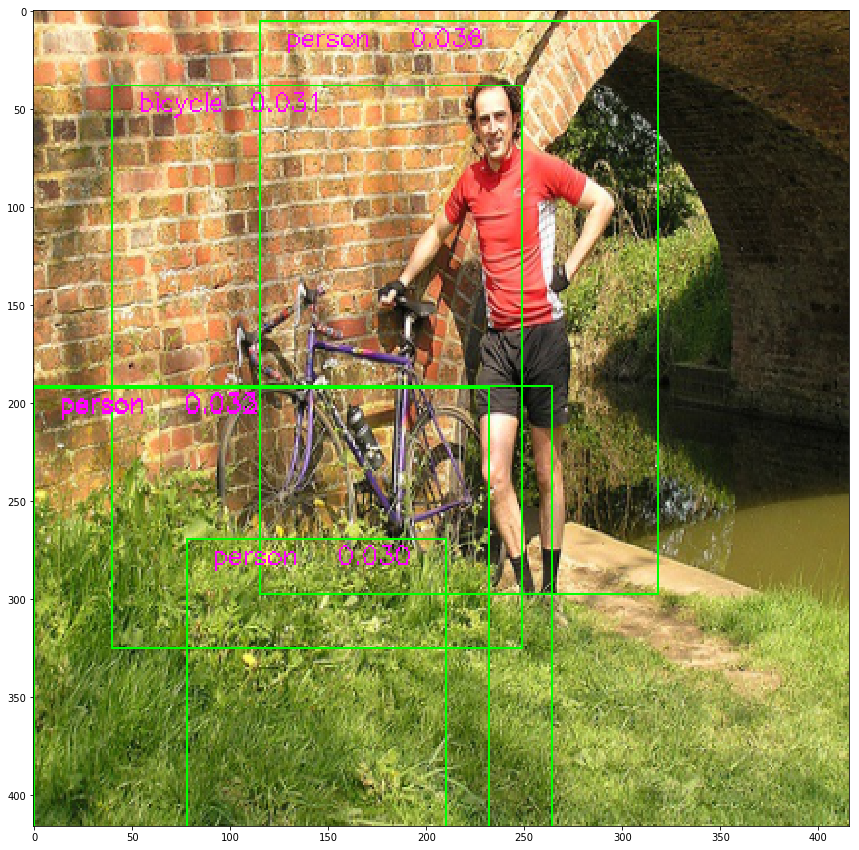

In [13]:
import cv2, copy
def draw_boxes(image, boxes, labels):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.score for box in boxes])
    score_rescaled /= np.min(score_rescaled)
    for sr, box in zip(score_rescaled,boxes):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:8} {:4.3f}".format(labels[box.label], box.score)
        print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=(0,1,0), 
                      thickness=sr)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)
        
    return image



ima = draw_boxes(X_test[0],final_boxes,LABELS)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()


# More examples 

In [14]:
np.random.seed(1)
Nsample   = 5
image_nms = list(np.random.choice(os.listdir(train_image_folder),Nsample))

person   0.032 xmin=  87,ymin=  35,xmax= 416,ymax= 390
person   0.031 xmin= 116,ymin=  32,xmax= 416,ymax= 386
person   0.032 xmin= 259,ymin=  61,xmax= 416,ymax= 351
person   0.031 xmin= 258,ymin=  92,xmax= 416,ymax= 378
sofa     0.039 xmin=  31,ymin= 100,xmax= 403,ymax= 416
person   0.066 xmin=  61,ymin= 101,xmax= 416,ymax= 416
person   0.032 xmin= 126,ymin= 129,xmax= 349,ymax= 414
person   0.033 xmin=  85,ymin= 101,xmax= 416,ymax= 416
person   0.039 xmin= 259,ymin= 122,xmax= 416,ymax= 410


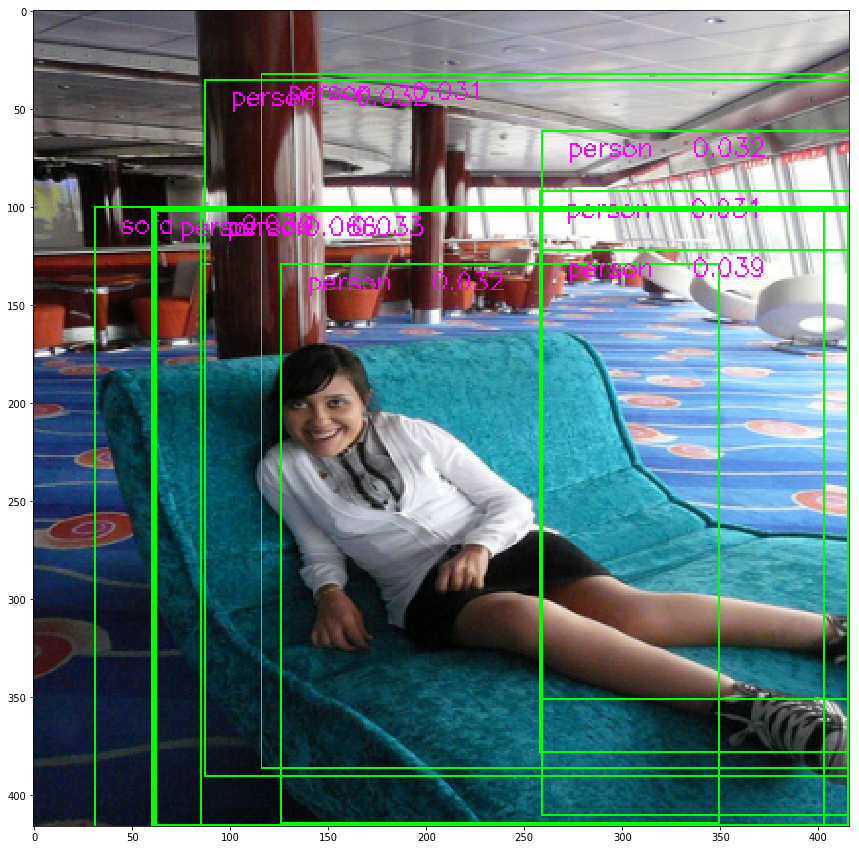

person   0.034 xmin=   5,ymin=   0,xmax= 215,ymax= 269
person   0.030 xmin=   0,ymin=   0,xmax= 231,ymax= 329
person   0.038 xmin=   0,ymin=   1,xmax= 158,ymax= 296
person   0.043 xmin=   0,ymin=   0,xmax= 262,ymax= 331
person   0.047 xmin=   0,ymin=   4,xmax= 191,ymax= 300
person   0.038 xmin=   0,ymin=   0,xmax= 292,ymax= 330
person   0.040 xmin=   2,ymin=   6,xmax= 210,ymax= 299
person   0.038 xmin=  24,ymin=   0,xmax= 397,ymax= 325
person   0.035 xmin=  55,ymin=   0,xmax= 416,ymax= 325
person   0.041 xmin=   0,ymin=   0,xmax= 233,ymax= 358
person   0.049 xmin=   0,ymin=  28,xmax= 159,ymax= 326
person   0.048 xmin=   0,ymin=   0,xmax= 263,ymax= 361
person   0.044 xmin=   0,ymin=  29,xmax= 189,ymax= 328
person   0.052 xmin=   0,ymin=   1,xmax= 291,ymax= 362
person   0.044 xmin=   4,ymin=  30,xmax= 210,ymax= 330
person   0.034 xmin=   0,ymin=   1,xmax= 323,ymax= 360
person   0.041 xmin=   0,ymin=   2,xmax= 360,ymax= 359
person   0.031 xmin=  69,ymin=  34,xmax= 278,ymax= 324
person   0

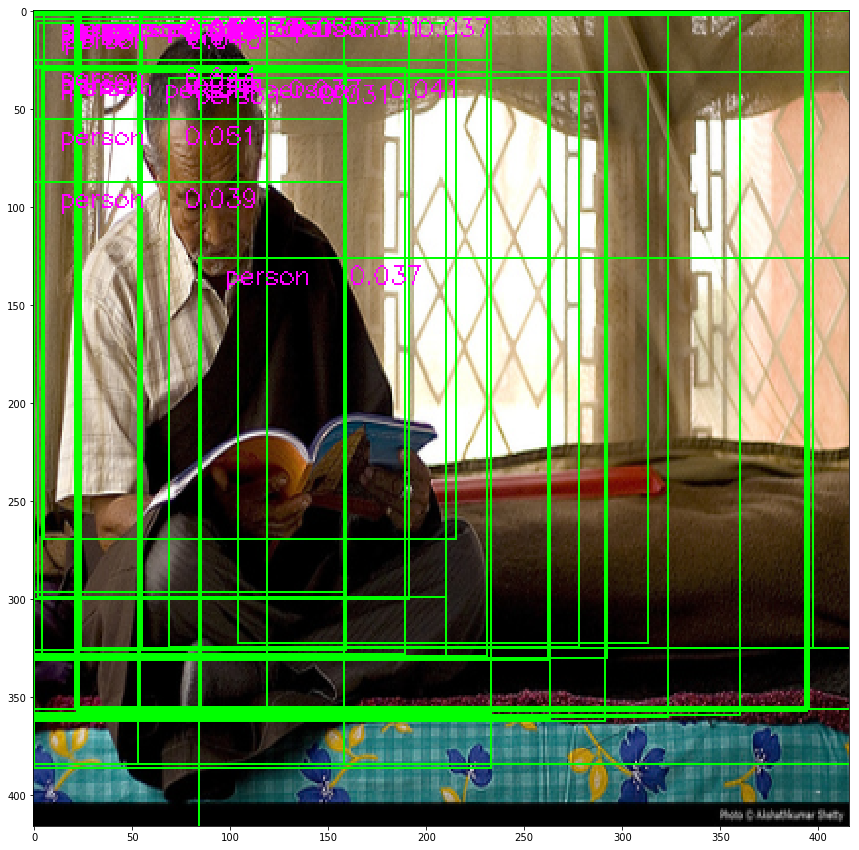

bottle   0.031 xmin=   0,ymin= 191,xmax= 232,ymax= 416
person   0.033 xmin= 181,ymin= 191,xmax= 416,ymax= 416


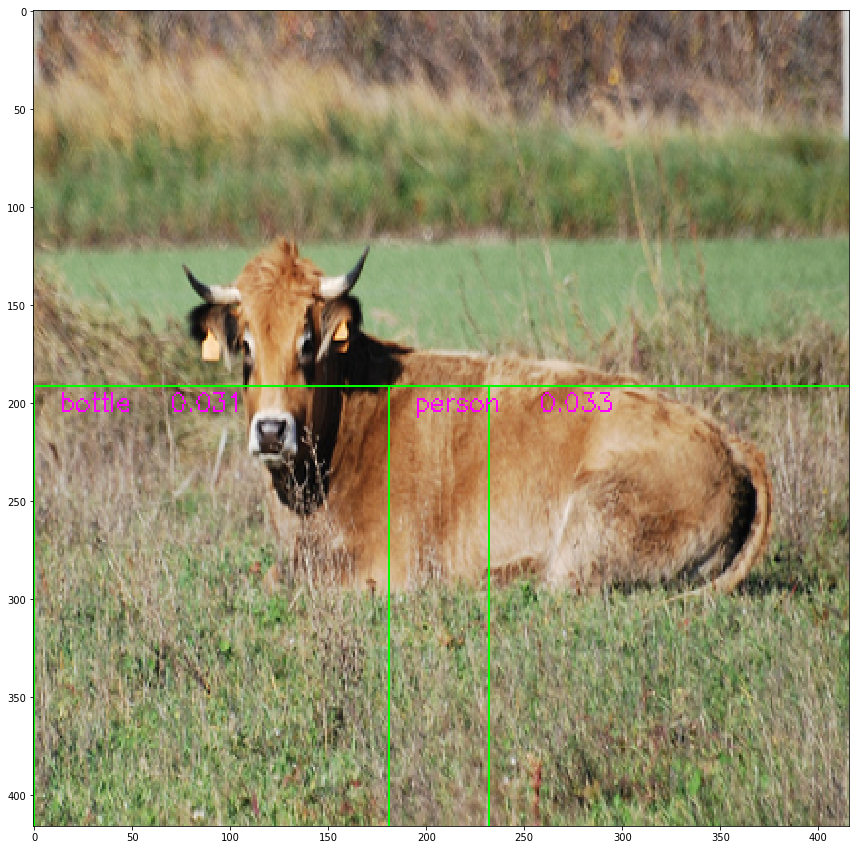

In [15]:
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
imageReader    = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
X_test         = []
for img_nm in image_nms:
    _path    = os.path.join(train_image_folder,img_nm)
    out      = imageReader.fit(_path)
    X_test.append(out)

X_test = np.array(X_test)

## model
dummy_array    = np.zeros((len(X_test),1,1,1,TRUE_BOX_BUFFER,4))
y_pred         = model.predict([X_test,dummy_array])

for iframe in range(len(y_pred)):
        netout         = y_pred[iframe] 
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,nms_threshold=0.1)
            ima = draw_boxes(X_test[iframe],final_boxes,LABELS)
            plt.figure(figsize=figsize)
            plt.imshow(ima); 
            plt.show()